In [51]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, log_loss, confusion_matrix
import pandas as pd
import numpy as np
from collections import defaultdict
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [9]:
dtrain = pd.read_csv('./data/train_clean.csv')

In [10]:
y = dtrain.label
X = dtrain.drop('label', inplace=False, axis=1)

In [17]:
y.value_counts()

1    422
0    192
Name: label, dtype: int64

In [13]:
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [15]:
y_train.value_counts()

1    337
0    154
Name: label, dtype: int64

In [16]:
y_cv.value_counts()

1    85
0    38
Name: label, dtype: int64

In [23]:
def get_summary_grid(grid):
    parms = list(grid.param_grid.keys())
    columns = ['Iter #']
    scorings = grid.scoring
    for scoring in scorings:
        for typ in ['train', 'test']:
            columns.append(f'{typ}_{scoring}')
    columns.extend(['fit_time', 'score_time'])
    for param in grid.param_grid.keys():
        columns.append(param)
    df = pd.DataFrame(columns=columns)
    cv_res = grid.cv_results_
    for col in columns[1:-len(parms)]:
        df[col] = cv_res['mean_' + col]
    items = 1
    for k, v in grid.param_grid.items():
        items *= len(v)
    df['Iter #'] = np.array(range(items)) + 1
    res = defaultdict(list)
    for each in grid.cv_results_['params']:
        for p in parms:
            res[p].append(each[p])
    for k, v in res.items():
        df[k] = v
    return df

In [41]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Percentage of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    A = (((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    labels = [0, 1]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in recall matrix",A.sum(axis=1))

## Decision Tree Baseliner

In [19]:
estimator = DecisionTreeClassifier(random_state=42)

In [20]:
params = {
    'max_depth': [*range(2, 11)],
    'min_samples_split': [*range(2, 200, 10)]
}

In [21]:
grid = GridSearchCV(estimator=estimator,
                    param_grid=params,
                    scoring={'accuracy', 'roc_auc', 'neg_log_loss'},
                    refit='neg_log_loss', # Because we are using multiple evaluation metrics
                    cv=StratifiedKFold(3),
                    return_train_score=True,
                    verbose=2,
                    n_jobs=-1)

In [22]:
grid.fit(X_train, y_train)

Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:    6.5s finished
/Users/mayukhsarkar/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_split': [2, 12, 22, 32, 42, 52, 62, 72, 82, 92, 102, 112, 122, 132, 142, 152, 162, 172, 182, 192]},
       pre_dispatch='2*n_jobs', refit='neg_log_loss',
       return_train_score=True,
       scoring={'accuracy', 'neg_log_loss', 'roc_auc'}, verbose=2)

In [29]:
grid_res = get_summary_grid(grid)
grid_res.sort_values('test_roc_auc', ascending=False).head()

,Iter #,train_accuracy,test_accuracy,train_neg_log_loss,test_neg_log_loss,train_roc_auc,test_roc_auc,fit_time,score_time,max_depth,min_samples_split
85,86,0.827903,0.757637,-0.399050,-1.790856,0.850662,0.716291,0.003524,0.006196,6,52
156,157,0.805483,0.788187,-0.454932,-0.658748,0.796329,0.713327,0.003494,0.006203,9,162
96,97,0.805483,0.788187,-0.454932,-0.658748,0.796329,0.713327,0.003354,0.006557,6,162
94,95,0.805483,0.788187,-0.454932,-0.658748,0.796329,0.713327,0.003306,0.006461,6,142
93,94,0.805483,0.788187,-0.454932,-0.658748,0.796329,0.713327,0.003305,0.006192,6,132


### How AUC_ROC changes as max_depth increases?

In [31]:
sns.set_style("whitegrid")
grid_res.rename({'min_samples_split': 'min_samples'}, axis=1, inplace=True)

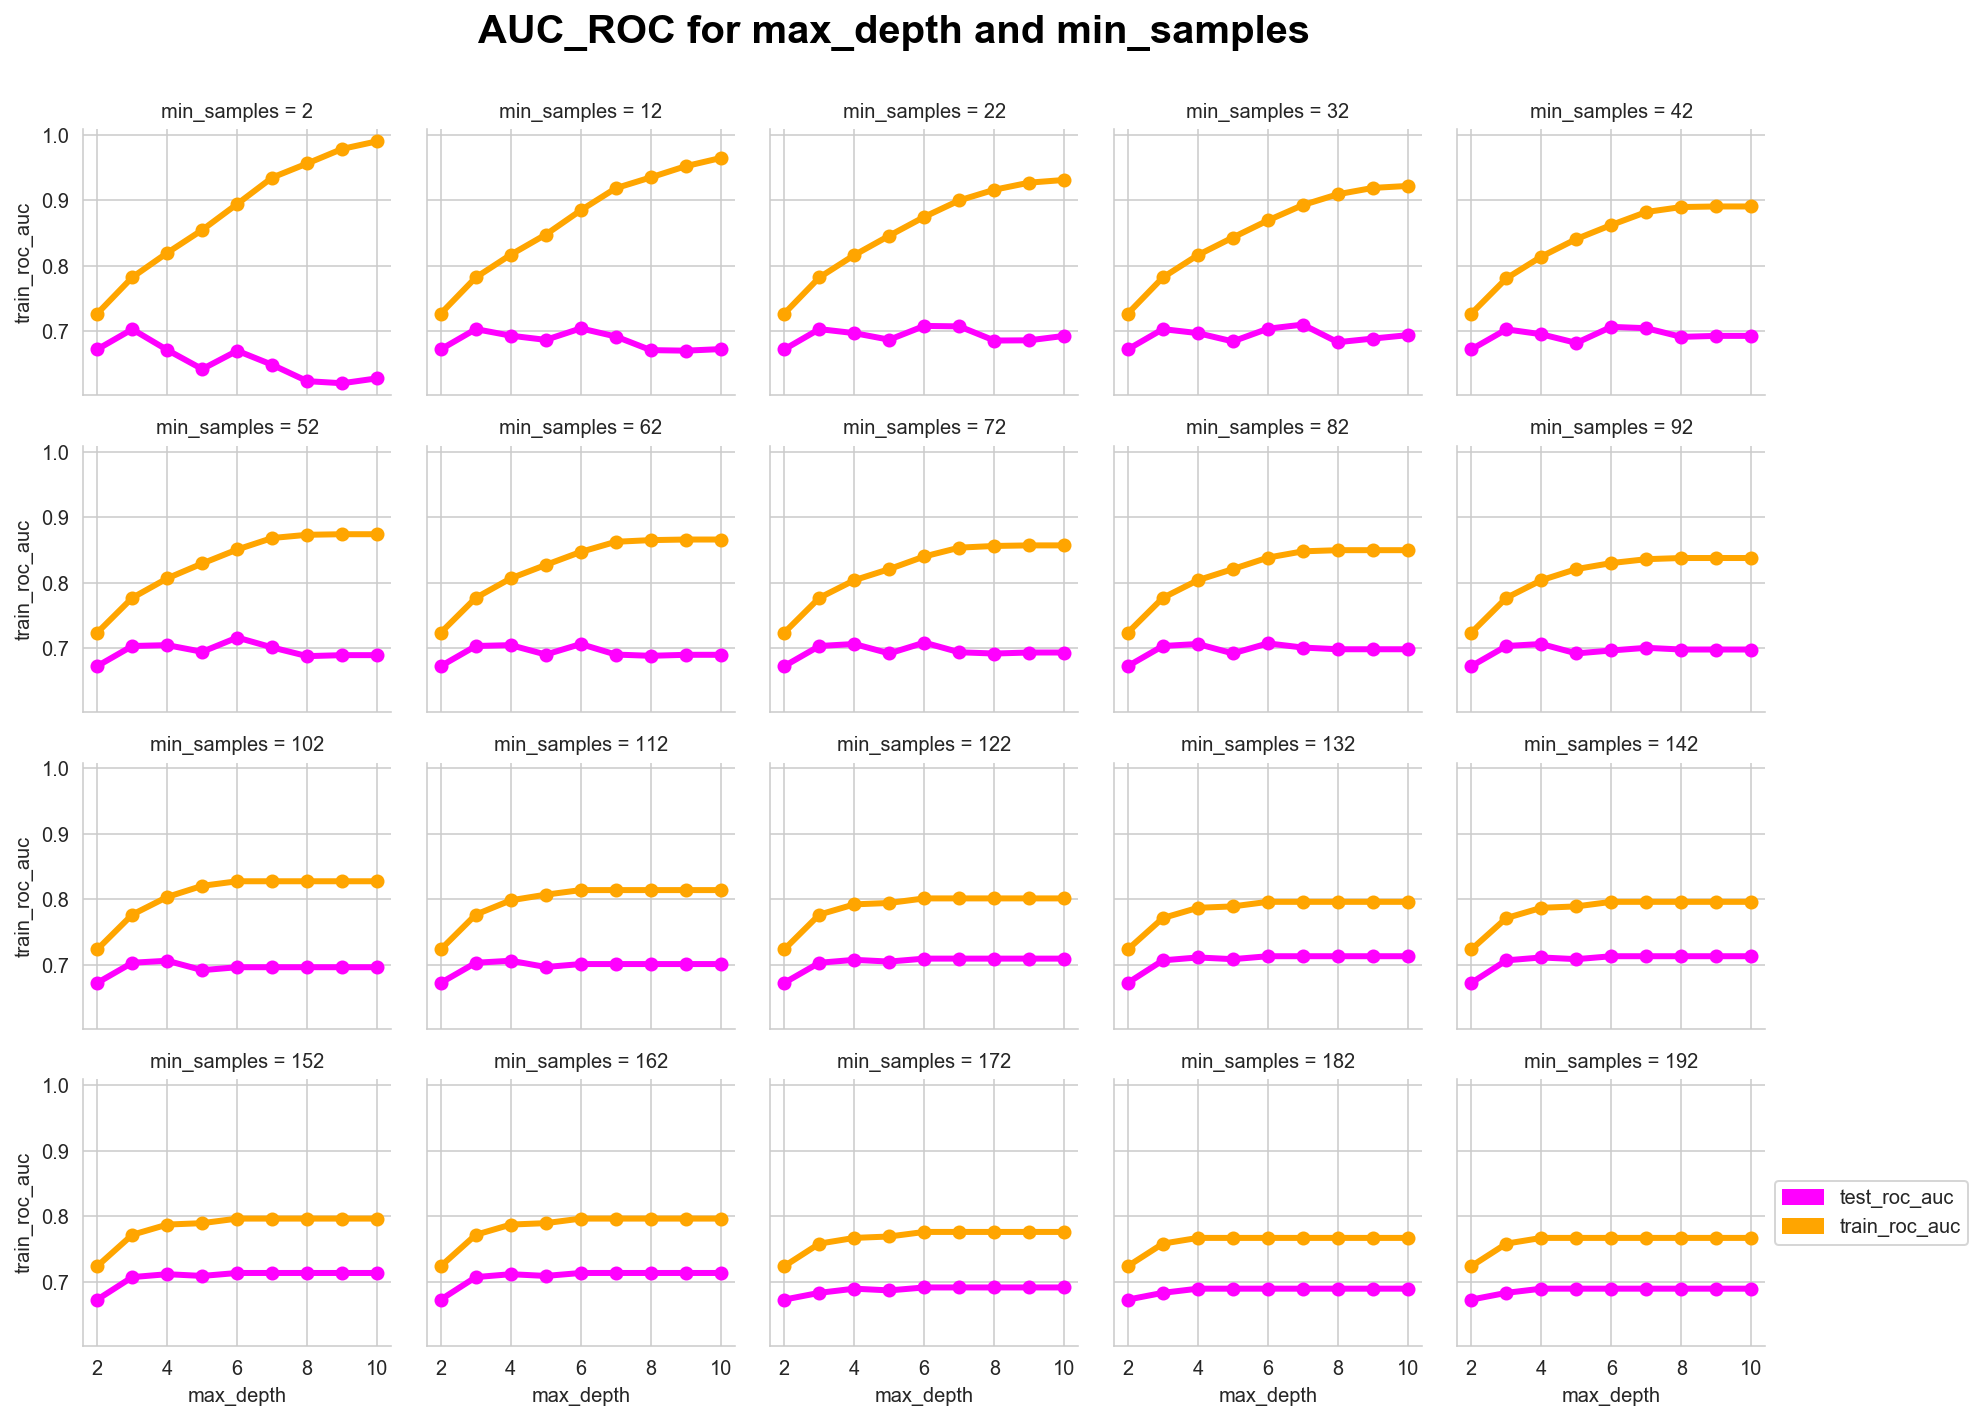

In [40]:
g = sns.FacetGrid(grid_res, col="min_samples", col_wrap=5, height=2.5)
g = g.map(plt.plot, "max_depth", "test_roc_auc", marker="o", color='magenta', linewidth=3)
g = g.map(plt.plot, "max_depth", "train_roc_auc", marker="o", color='orange', linewidth=3)
# legend_labels  = ['test_f1', 'train_f1']
# plt.legend(handles=legend_patches)
legend_patches = [matplotlib.patches.Patch(color='magenta', label='test_roc_auc'),
                 matplotlib.patches.Patch(color='orange', label='train_roc_auc')]
plt.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1,0.5))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('AUC_ROC for max_depth and min_samples', size=20, weight='bold', color='black');

- It seems at lower values of `min_samples` the model is overftting
- By eyeballing, it seems that `max_depth` of 4 to 6 and `min_samples` of 142 is a good fit
- We are reporting the auc_roc but we are tuning the model based on the log_loss.

In [46]:
pred_y = grid.best_estimator_.predict_proba(X_cv)

In [48]:
print('The logloss of the model is:', log_loss(y_cv, pred_y))

The logloss of the model is: 0.6820083437543909


In [49]:
pred_y_raw = grid.best_estimator_.predict(X_cv)

Percentage of misclassified points  14.634146341463413
-------------------------------------------------- Confusion matrix --------------------------------------------------


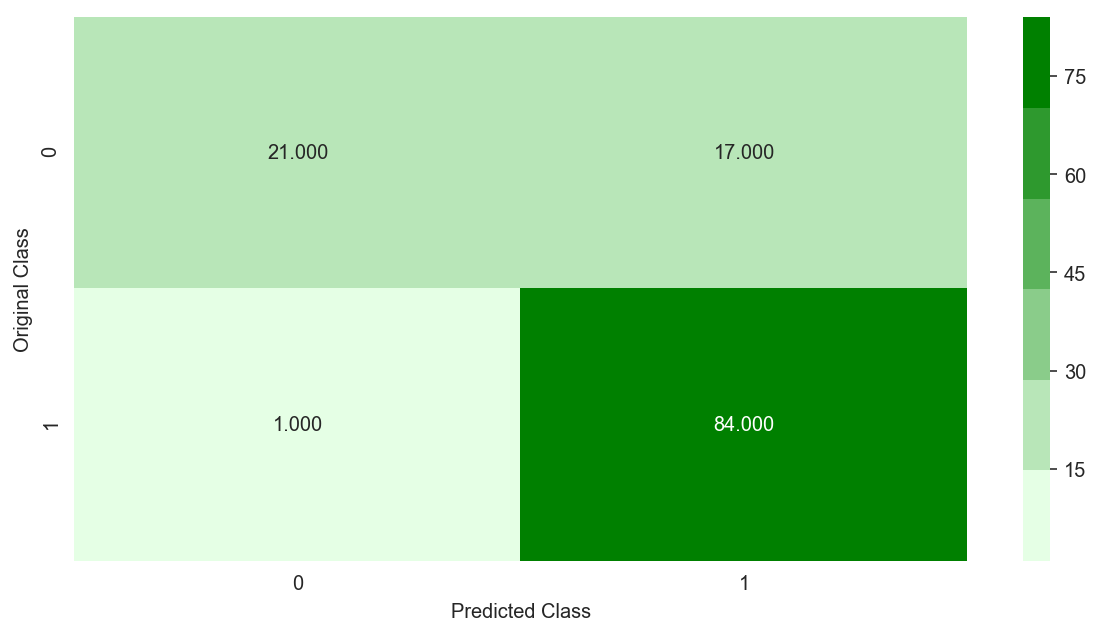

-------------------------------------------------- Precision matrix --------------------------------------------------


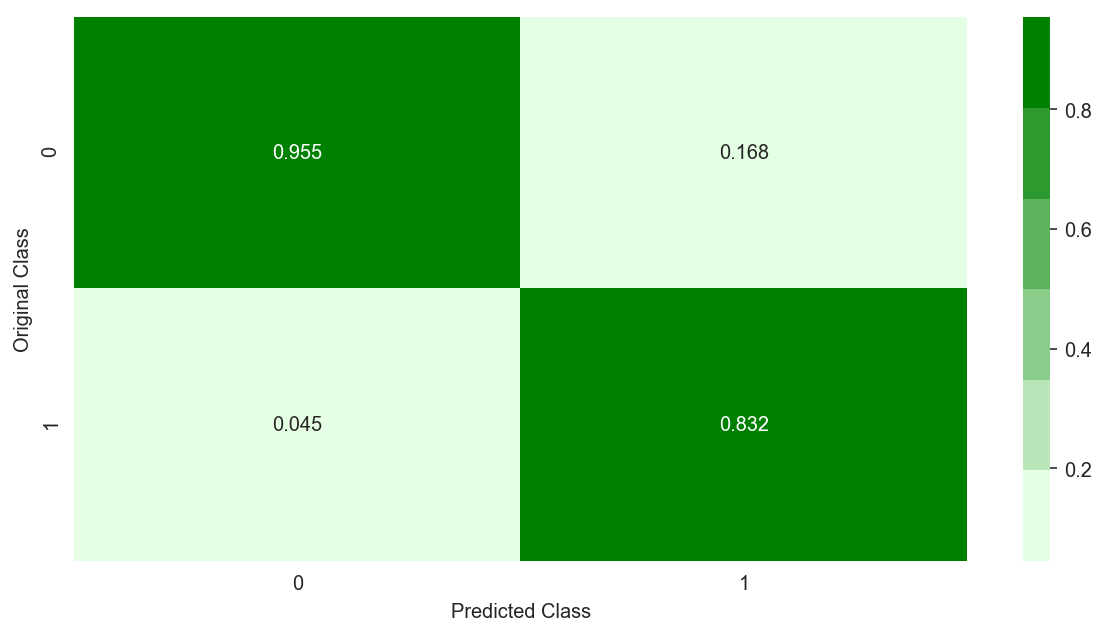

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


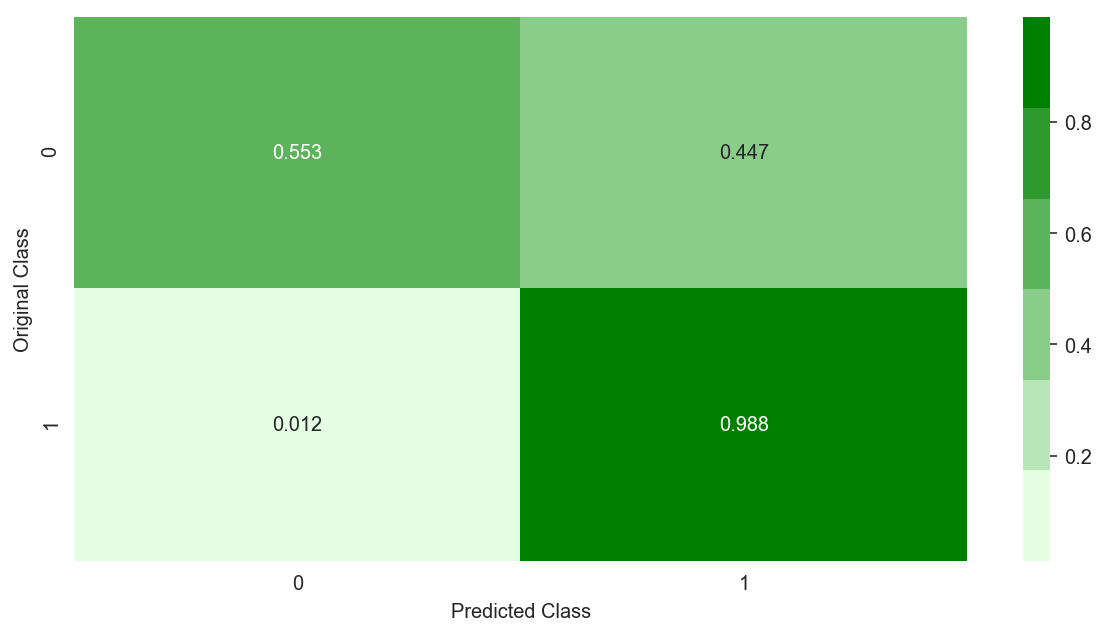

Sum of rows in recall matrix [1. 1.]


In [52]:
plot_confusion_matrix(y_cv, pred_y_raw)

- Recall for the class 0 is not staisfactory.
- Let's see if more complicated model can solve it or not

## Random Forest

In [57]:
params = {
    'max_depth': [2, 5, 7, 10, 12, 15],  
    'min_samples_split': [2, 4, 6, 10, 15] 
}
estimator = RandomForestClassifier(random_state=42, 
                                   n_estimators=100,
                                   class_weight='balanced')

In [58]:
grid = GridSearchCV(estimator=estimator,
                    param_grid=params,
                    scoring={'accuracy', 'roc_auc', 'neg_log_loss'},
                    refit='neg_log_loss', # Because we are using multiple evaluation metrics
                    cv=StratifiedKFold(3),
                    return_train_score=True,
                    verbose=2,
                    n_jobs=-1)

In [59]:
grid.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    6.2s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [2, 5, 7, 10, 12, 15], 'min_samples_split': [2, 4, 6, 10, 15]},
       pre_dispatch='2*n_jobs', refit='neg_log_loss',
       return_train_score=True,
       scoring={'accuracy', 'neg_log_loss', 'roc_auc'}, verbose=2)

In [60]:
grid_res = get_summary_grid(grid)
grid_res.sort_values('test_roc_auc', ascending=False).head()

,Iter #,train_accuracy,test_accuracy,train_neg_log_loss,test_neg_log_loss,train_roc_auc,test_roc_auc,fit_time,score_time,max_depth,min_samples_split
15,16,0.991851,0.773931,-0.208119,-0.527626,0.999942,0.742529,0.154275,0.048734,10,2
25,26,1.000000,0.771894,-0.141258,-0.530443,1.000000,0.742060,0.155718,0.048550,15,2
27,28,0.974550,0.780041,-0.266927,-0.527832,0.996334,0.737901,0.148767,0.051010,15,6
22,23,0.972517,0.771894,-0.272411,-0.529206,0.995758,0.734961,0.188220,0.065237,12,6
20,21,0.997961,0.767821,-0.164059,-0.531629,1.000000,0.734651,0.153384,0.048729,12,2


In [61]:
pred_y = grid.best_estimator_.predict_proba(X_cv)

In [62]:
print('The logloss of the model is:', log_loss(y_cv, pred_y))

The logloss of the model is: 0.4751035889397401


In [63]:
pred_y_raw = grid.best_estimator_.predict(X_cv)

Percentage of misclassified points  20.32520325203252
-------------------------------------------------- Confusion matrix --------------------------------------------------


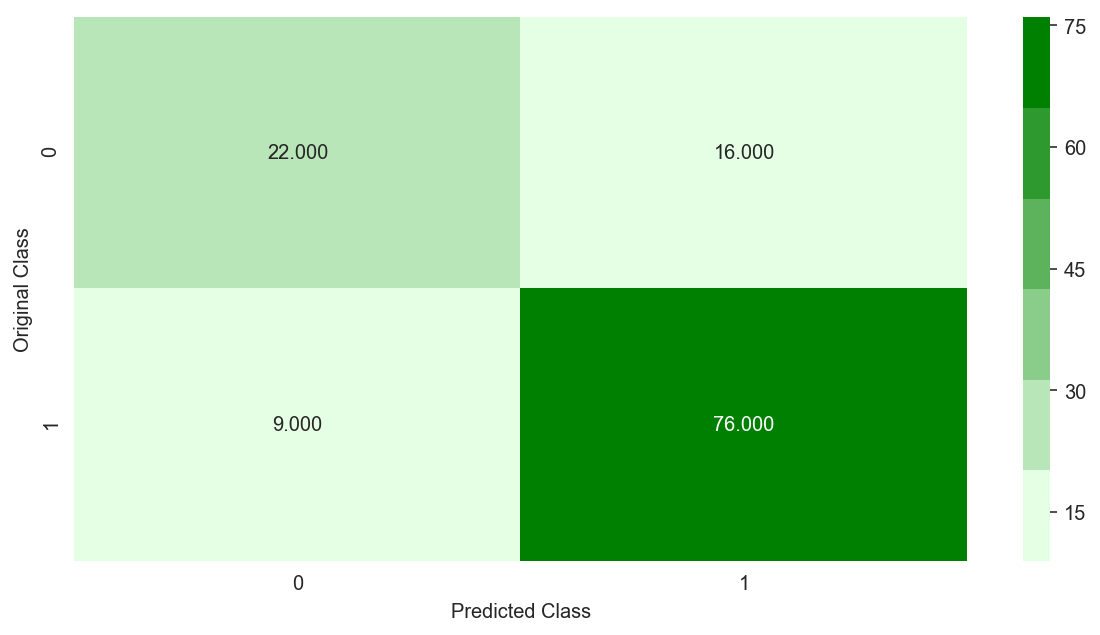

-------------------------------------------------- Precision matrix --------------------------------------------------


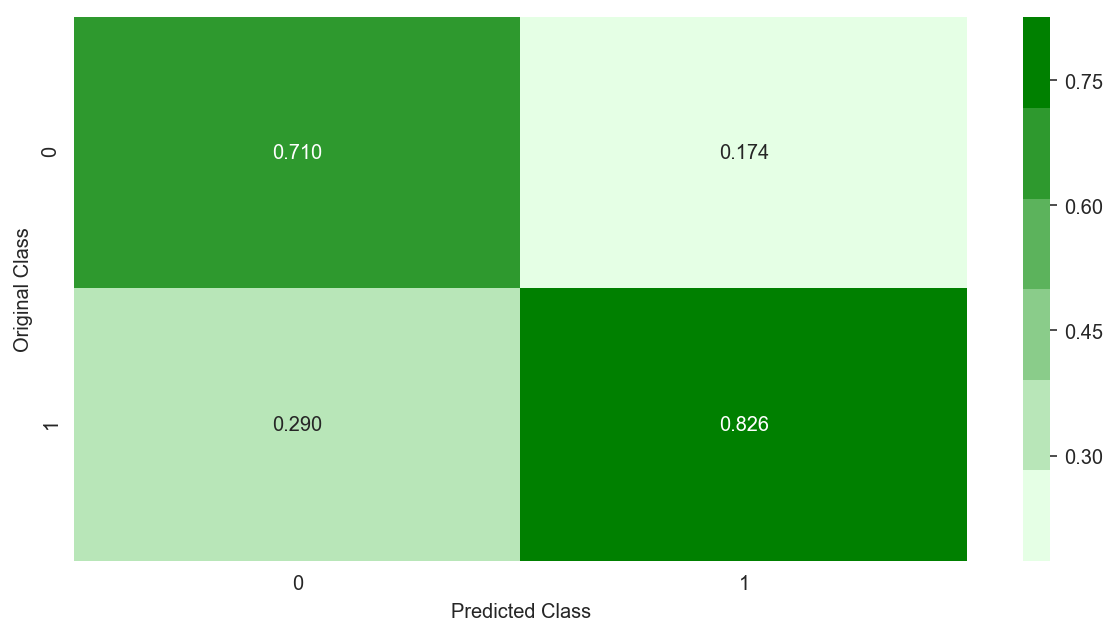

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


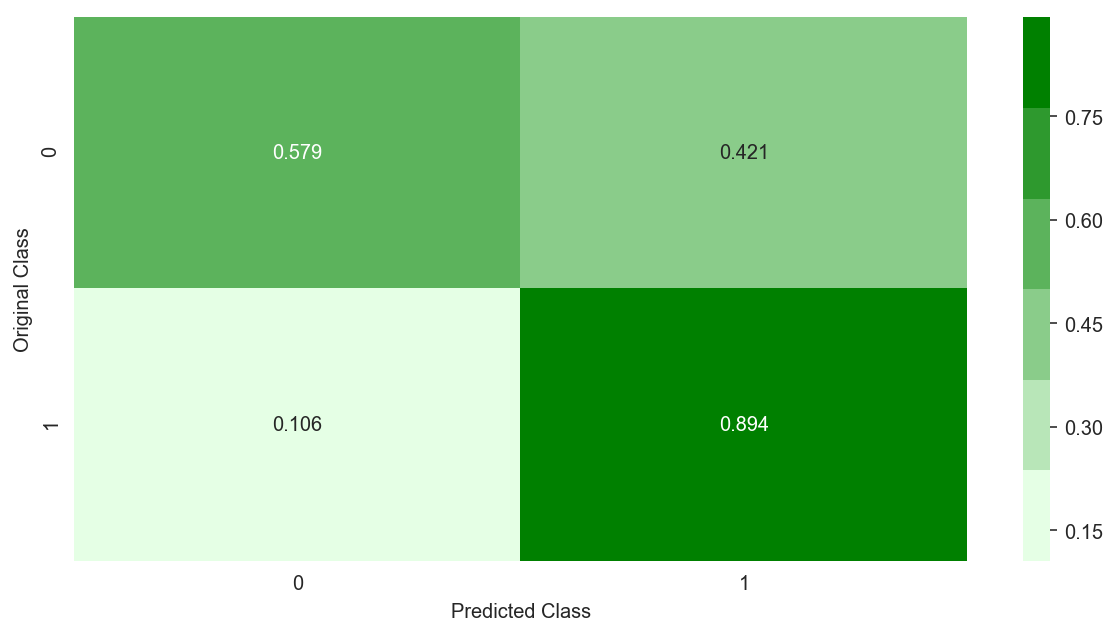

Sum of rows in recall matrix [1. 1.]


In [64]:
plot_confusion_matrix(y_cv, pred_y_raw)

- Random Forest is clearly overfitting as it's performance is very much inferior for both the class labels.
- We now would go for LightGBM which much more sensetive regularisation

## LightGBM

In [69]:
params = {
    'max_depth': [2, 4, 6],  # Typically small value for low variance 
    'subsample': [0.5, 0.75, 1.0], # Row sampling like Random Forest 
    'colsample_bytree': [0.3, 0.5, 0.7, 1.0],  # Column sampling like Random Forest
    'num_leaves': [2**2, 2**4, 2**6],  # Should be according to the max_depth (small)
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 2]
}
estimator = lgb.LGBMClassifier(random_state=42, 
                                silent=False, 
                                n_jobs=1, 
                                class_weight='balanced')

In [70]:
grid = GridSearchCV(estimator=estimator,
                    n_jobs=-1,
                    param_grid=params,
                    scoring={'neg_log_loss', 'accuracy'},
                    refit='neg_log_loss', # Because we are using multiple scoring metrics
                    cv=StratifiedKFold(4, shuffle=True), # Because some class labels are imbalanced
                    return_train_score=True,
                    verbose=2)

In [ ]:
grid.fit(X_train, y_train)

Fitting 4 folds for each of 756 candidates, totalling 3024 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 1238 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 1968 tasks      | elapsed:   53.5s
